In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import pickle
import dill

import numpy as np
import pandas as pd

from scipy.stats import binned_statistic
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import gm2
import trfp
import plotting_functions as plt2
# import analysis_helper as helper
# import helper_function_candidates as helper_old
# import df_analysis_funcs as df_func
import helper_functions as helper

import muon_dist_config_run1 as dist_config
import field_map_config_run1 as map_config

from IPython.display import clear_output

# blinds = np.loadtxt('blinds.txt')
pair_dict = map_config.pair_dict

def bins(df, num_bins):
    xy_df = df.groupby(pd.cut(df.index.values, num_bins)).mean()
    x = np.empty(xy_df.shape[0])
    ii = 0
    for interval in xy_df.index:
        x[ii] = interval.mid
        ii = ii + 1
    y = xy_df.values
    return x, y

Welcome to JupyROOT 6.22/02


In [2]:
fig_width = 3.375 * 2  # inches, one column

plt.style.use('gm2.mplstyle')

xlabel_kwargs = dict(horizontalalignment='right', x=1.0, verticalalignment='bottom', y=0.0)
ylabel_kwargs = dict(horizontalalignment='right', x=0.0, verticalalignment='bottom', y=1.0, labelpad=10)

In [3]:
run = '1a'

filename = 'hdf5/2020-09-30_run_' + run + '.h5'

interp_dfs, keys, subrun_df = helper.read_dfs(filename)
run_pair_dict = pair_dict[run]

moment_dfs = helper.interp_to_moment(interp_dfs, keys)
# moment_dfs = blind_moments(moment_dfs, keys, blinds)
corrected_dfs = helper.moment_to_corrected(moment_dfs, keys)

baselines = helper.station_average(corrected_dfs, keys)

## for endgame only
# for item in baselines:
#     baselines[item]['tr_df_9'] = baselines[item]['tr_df_8']
# baselines['time']['tr_df_9'] = baselines['time']['tr_df_7']

vtm_dfs = helper.calculate_vtms(corrected_dfs, keys, baselines, run_pair_dict)

bloch_style_dfs = helper.bloch_style_moments(corrected_dfs, keys)
baselines_bloch = helper.station_average(bloch_style_dfs, keys)

## for endgame only
# for item in baselines_bloch:
#     baselines_bloch[item]['tr_df_9'] = baselines_bloch[item]['tr_df_8']
# baselines_bloch['time']['tr_df_9'] = baselines_bloch['time']['tr_df_7']

vtm_dfs_bloch = helper.calculate_vtms(bloch_style_dfs, keys, baselines_bloch, run_pair_dict)

# clear_output()

# for key in vtm_dfs.keys():
#     a = vtm_dfs[key].index.values
#     bins = np.array([a,a]).T.flatten()[:len(a)]

#     vtm_2_sec_df = vtm_dfs_bloch[key].groupby(bins).mean()
#     vtm_2_sec_df = vtm_2_sec_df.set_index((a[::2]+0.5))

#     weight = trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1]
#     weight[2] = weight[2] + 360

#     vtm_2_sec_azi_avg_df = pd.DataFrame(index=vtm_2_sec_df.index)

#     for m in range(9):
#         stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
#         vtm_2_sec_azi_avg_df['m'+str(m+1)] = vtm_2_sec_df[stm_list].multiply(weight).sum(axis=1)/360

#     # need to save 4 data frames

#     save_key = 'run_' + run + key[6]
#     save_dir = 'hdf5/'
#     save_prefix = '2020-09-30_'

#     print 'Saving ' + save_key

#     # save purcell style

#     save_path = save_dir + save_prefix + 'purcell_maps.h5'
#     vtm_dfs[key].to_hdf(save_path, key=save_key)

#     # save hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps.h5'
#     vtm_dfs_bloch[key].to_hdf(save_path, key=save_key)

#     # save 2 sec hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps_2sec.h5'
#     vtm_2_sec_df.to_hdf(save_path, key=save_key)

#     # save 2 sec azi avg hybrid

#     save_path = save_dir + save_prefix + 'hybrid_maps_2sec_aziavg.h5'
#     vtm_2_sec_azi_avg_df.to_hdf(save_path, key=save_key)


Reading fp_df_1

Reading tr_df_1

Reading tr_df_2

Calculating moments for fp_df_1
Finished calculating all moments for 257281 events.      

Calculating moments for tr_df_1
Finished calculating all moments for 4386 events.

Calculating moments for tr_df_2
Finished calculating all moments for 4363 events.

Removing trolley footprints for tr_df_1
Removing trolley image from station 71.              
Removing trolley footprints for tr_df_2
Removing trolley image from station 71.              


Calculating trolley run baselines.

Calculating VTMs

Implementing Bloch-style treatment of stations 1, 3, and 5.
fp_df_1
tr_df_1
tr_df_2
m5
Calculating trolley run baselines.

Calculating VTMs


In [4]:
def bins(df, num_bins):
    xy_df = df.groupby(pd.cut(df.index.values, num_bins)).mean()
    x = np.empty(xy_df.size)
    ii = 0
    for interval in xy_df.index:
        x[ii] = interval.mid
        ii = ii + 1
    y = xy_df.values
    return x, y

Removing trolley image from station 10.


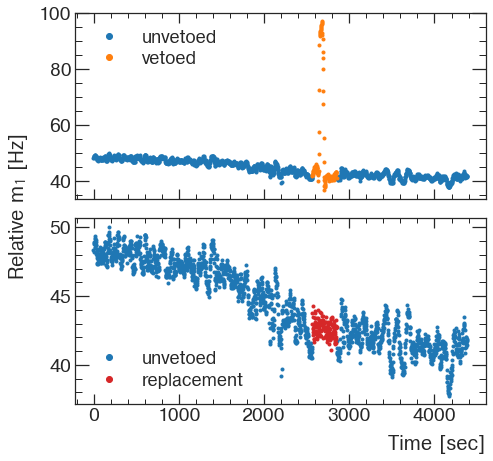

In [5]:
## fig:footprint_replacement

fig_name = 'fig_footprint_replacement'

st = 10
m = 1
df = 'tr_df_1'

veto_extent=25
no_mask_df = moment_dfs[df].copy()
t0 = no_mask_df.index.values[0]
no_mask_df.index -= t0
index = no_mask_df.index.values

print '\rRemoving trolley image from station '+str(st)+'.',

# veto when trolley is close to station

veto_low = (trfp.STATION_BARCODE_PHI[st]-1.5-veto_extent/2)%360
veto_high = (trfp.STATION_BARCODE_PHI[st]-1.5+veto_extent/2)%360
if veto_low < veto_high:
    veto_mask = (no_mask_df['tr_phi']>veto_low) & (no_mask_df['tr_phi']<veto_high)
else:  # this happens when wrapping around 360 deg
    veto_mask = (no_mask_df['tr_phi']>veto_low) | (no_mask_df['tr_phi']<veto_high)

# no longer dealing with m6 in the fixed probes


stm = 'st'+str(st)+',m'+str(m)

# calculate local drift

times = no_mask_df.index.values[~veto_mask]
freqs = no_mask_df[stm][~veto_mask]

local_drift_fit = np.polyfit(times, freqs, 5)
local_drift = np.polyval(local_drift_fit, no_mask_df.index.values)

# need to average other side of ring
all_good_stations = np.arange(6,72)  # not using the inflector stations
no_ground_loop_stations = np.array(range(6,16)+range(64,72))  # vaid for 25 deg veto

# next need to average all good stations that are not within 3 of current station
if st not in range(16, 23):  # note that these ranged were chosen for 25 deg veto
    averaging_stations = np.delete(all_good_stations,
                                   np.argwhere((np.abs((all_good_stations - st)%72)<=3)
                                              | (np.abs((all_good_stations - st)%72)>=69))
                                  )
else:
    averaging_stations = np.delete(no_ground_loop_stations,
                                   np.argwhere((np.abs((no_ground_loop_stations - st)%72)<=3)
                                              | (np.abs((no_ground_loop_stations - st)%72)>=69))
                                  )
avg_stms = ['st'+str(avg_st)+',m'+str(m+1) for avg_st in averaging_stations]
replacement = no_mask_df[avg_stms].mean(axis=1)

# calculate global drift
global_drift_fit = np.polyfit(index[veto_mask], replacement[veto_mask], 1)
global_drift = np.polyval(global_drift_fit, index[veto_mask])

# subtract global drift from replacement
replacement = replacement[veto_mask] - global_drift

# add local drift
replacement = replacement + local_drift[veto_mask]

no_mask_df[stm][veto_mask] = replacement

raw_data = moment_dfs[df][stm].copy()
raw_data.index -= raw_data.index.values[0]

x0, y0 = bins(raw_data[~veto_mask], raw_data[~veto_mask].size/2)
x3, y3 = bins(raw_data[veto_mask], raw_data[veto_mask].size/2)

unvetoed = no_mask_df[stm][~veto_mask].copy()
x1, y1 = bins(unvetoed, unvetoed.size/2)
replace = no_mask_df[stm][veto_mask].copy()
x2, y2 = bins(replace, replace.size/2)

fig2, axs2 = plt.subplots(2, 1, sharex=True)

axs2[0].plot(x0, y0+61.74e6-61.792e6, '.', ms=6, label='unvetoed')
axs2[0].plot(x3, y3+61.74e6-61.792e6, '.', ms=6, label='vetoed')
axs2[0].legend(markerscale=2, loc='upper left')

axs2[1].plot(x1, y1+61.74e6-61.792e6, '.', ms=6, label='unvetoed')
axs2[1].plot(x2, y2+61.74e6-61.792e6, '.', ms=6, label='replacement', color='C3')
axs2[1].legend(markerscale=2, loc='lower left')

axs2[1].set_xlabel('Time [sec]', **xlabel_kwargs)
# axs2[0].set_ylabel('NMR freq [Hz]', **ylabel_kwargs)
# axs2[1].set_ylabel('NMR freq [Hz]', **ylabel_kwargs)
fig2.text(-0.025, 0.55, r'Relative m$_1$ [Hz]', va='center', rotation='vertical', fontsize=20)

# fig2.text(0, 1, 'NMR freq [Hz]', va='center', rotation='vertical')

fig2.align_ylabels()
fig2.set_size_inches(fig_width, fig_width)
fig2.tight_layout()

fig2.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
pickle.dump(axs2, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

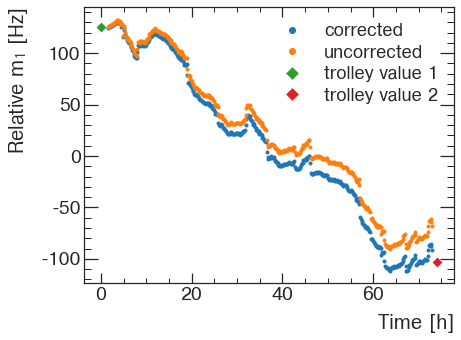

In [12]:
## fig:backward_interp
fig_name = 'fig_backward_interp'

fig1, axs1 = plt.subplots(1,1)

st = 16
m = 1

df = 'fp_df_1'
stm = 'st'+str(st)+',m'+str(m)
stm5 = 'st'+str(st)+',m5'

x0 = 0
x1 = (baselines['time']['tr_df_2'][st] - baselines['time']['tr_df_1'][st])/3600.


pre_corr = (moment_dfs[df][stm] - baselines['fp']['tr_df_1'][st,m-1] + baselines['tr']['tr_df_1'][st,m-1]
            + 2.631605 * (moment_dfs[df][stm5] - baselines['fp']['tr_df_1'][st,4])
           )
x, pre_corr = bins(pre_corr, pre_corr.size/600)
post_corr = vtm_dfs[df][stm]
_, post_corr = bins(post_corr, post_corr.size/600)

x = x - baselines['time']['tr_df_1'][st]
x = x/3600.



axs1.plot(x, post_corr+61.74e6-61.792e6, '.', markersize=6, label='corrected')
axs1.plot(x, pre_corr+61.74e6-61.792e6, '.', markersize=6, label='uncorrected')

axs1.plot(x0, baselines['tr']['tr_df_1'][st,m-1]+61.74e6-61.792e6, 'D', color='C2', mew=5, markersize=2, label='trolley value 1')
axs1.plot(x1, baselines['tr']['tr_df_2'][st,m-1]+61.74e6-61.792e6, 'D', color='C3', mew=5, markersize=2, label='trolley value 2')

axs1.legend(markerscale=2)

axs1.set_xlabel('Time [h]', **xlabel_kwargs)
axs1.set_ylabel(r'Relative m$_1$ [Hz]', **ylabel_kwargs)

fig1.set_size_inches(fig_width,0.75*fig_width)
fig1.tight_layout()

fig1.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
pickle.dump(axs1, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## fig:team_diffs

# fig_name = 'fig_team_diffs'

# bloch_df = pd.read_csv('/data2/scharity/Run1/FinalUnblindingOct2020/60Hr_3956-3997_for_alec.csv', index_col=0)
# purcell_df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_1a1')

# weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
# weight[2] = (weight[2] + 360)
# weight = weight/360

# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     purcell_df['m'+str(m+1)] = purcell_df[stm].multiply(weight).sum(axis=1)

# fig3, axs3 = plt.subplots(2, 1, sharex=True)

# xp, yp = bins(purcell_df['m1'], num_bins=purcell_df['m1'].size/1000)
# xb, yb = bins(bloch_df['dipole'], num_bins=bloch_df['dipole'].size/1)
# yb *= 61.79

# xd = xp
# yd = np.interp(xp, xb, yb) - yp

# xb = (xb - xp[0])/3600
# xd = (xd - xp[0])/3600
# xp = (xp - xp[0])/3600

# axs3[0].plot(xp, yp + 61.74e6, '.', label='Team 2')
# axs3[0].plot(xb, yb + 61.74e6, '.', label='Team 1')
# axs3[0].legend(markerscale=2)
# axs3[1].plot(xd, yd, '.')

# axs3[0].set_ylabel('NMR freq [Hz]', **ylabel_kwargs)
# axs3[1].set_ylabel('Team diff [Hz]', **ylabel_kwargs)
# axs3[1].set_xlabel('Time [h]', **xlabel_kwargs)

# fig3.set_size_inches(fig_width, fig_width)
# fig3.tight_layout()

# fig3.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs3, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## fig:team_diffs_avg

# fig_name = 'fig_team_diffs_avg'

# bloch_purcell_dict = {'run_1a1':'/data2/scharity/Run1/FinalUnblindingOct2020/60Hr_3956-3997_for_alec.csv',
#                       'run_1b1':'/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4058-4098_for_alec.csv',
#                       'run_1b2':'/data2/scharity/Run1/FinalUnblindingOct2020/HighKick_4098-4138_for_alec.csv',
#                       'run_1c1':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4138-4181_for_alec.csv',
#                       'run_1c2':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4189-4226_for_alec.csv',
#                       'run_1c3':'/data2/scharity/Run1/FinalUnblindingOct2020/9day_4226-4265_for_alec.csv',
#                       'run_1d2':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5054-5103_for_alec.csv',
#                       'run_1d3':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5117-5157_for_alec.csv',
#                       'run_1d4':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5169-5217_for_alec.csv',
#                       'run_1d5':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5217-5259_for_alec.csv',
#                       'run_1d6':'/data2/scharity/Run1/FinalUnblindingOct2020/endgame_5259-5303_for_alec.csv'}

# bloch_avg = np.empty(11)
# purc_avg = np.empty(11)
# diff_avg = np.empty(11)

# weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
# weight[2] = (weight[2] + 360)
# weight = weight/360

# ii = 0
# for run in bloch_purcell_dict:
#     print run
#     bloch_df = pd.read_csv(bloch_purcell_dict[run], index_col=0)
#     purcell_df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key=run)
#     for m in range(9):
#         stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#         purcell_df['m'+str(m+1)] = purcell_df[stm].multiply(weight).sum(axis=1)
#     xp, yp = bins(purcell_df['m1'], num_bins=purcell_df['m1'].size/1000)
#     xb, yb = bins(bloch_df['dipole'], num_bins=bloch_df['dipole'].size/1)
#     yb *= 61.79

#     xd = xp
#     yd = np.interp(xp, xb, yb) - yp

#     xb = (xb - xp[0])/3600
#     xd = (xd - xp[0])/3600
#     xp = (xp - xp[0])/3600
    
#     bloch_avg[ii] = np.polyfit(xb, yb, 0)
#     purc_avg[ii] = np.polyfit(xp, yp, 0)
#     diff_avg[ii] = np.polyfit(xd, yd, 0)
    
#     ii += 1


# fig_name = 'fig_team_diffs_avg'

# fig4, axs4 = plt.subplots(1,1)

# axs4.hist(diff_avg, bins=np.arange(-1.75, 2, 0.5))
# axs4.vlines(np.mean(diff_avg), 0, 3, color='C1', linewidths=3, label='mean')
# axs4.vlines(np.mean(diff_avg) - np.std(diff_avg)/np.sqrt(11), 0, 3, color='C1', linewidths=3, linestyles='dotted', label='mean error')
# axs4.vlines(np.mean(diff_avg) + np.std(diff_avg)/np.sqrt(11), 0, 3, color='C1', linewidths=3, linestyles='dotted')
# axs4.legend(markerscale=2)

# axs4.set_xlabel('Avg team diff [Hz]')
# axs4.set_ylabel('Number of trolley pairs')
# axs4.set_yticks([0,1,2,3])

# fig4.set_size_inches(fig_width, 0.75*fig_width)
# fig4.tight_layout()

# fig4.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs4, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [60]:
## fig:run1_track

fig_name = 'fig_run1_track'

weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

x = np.empty(0)
y1 = np.empty(0)
y2 = np.empty(0)
for run in map_config.subruns:
    print run
    df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
    for m in range(2):
        stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
        df['m'+str(m+1)] = df[stm].multiply(weight).sum(axis=1)
    _x, _y1 = bins(df['m1'], df['m1'].size/1200)
    _x, _y2 = bins(df['m2'], df['m2'].size/1200)
    x = np.append(x, _x)
    y1 = np.append(y1, _y1)
    y2 = np.append(y2, _y2)
    
x = (x-x[0])/(3600*24)


1a1
1b1
1b2
1c1
1c2
1c3
1d2
1d3
1d4
1d5
1d6


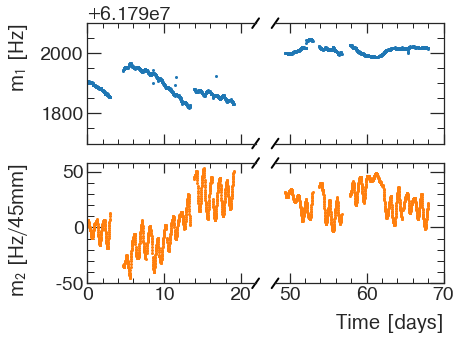

In [61]:
fig_name = 'fig_run1_track'

fig5, axs5 = plt.subplots(2, 2)

axs5[0,0].plot(x, y1 + 61.74e6, '.', ms=4)
axs5[0,0].set_xlim([0,21.9])
axs5[0,0].set_ylim([1700 + 61.79e6, 2100 + 61.79e6])
axs5[0,0].set_xticks([0,10,20])

axs5[0,1].plot(x, y1 + 61.74e6 - 61.79e6, '.', ms=4, label='dipole')
axs5[0,1].set_xlim([48.1,70])
axs5[0,1].set_ylim([1700,2100])

axs5[0,0].spines['right'].set_visible(False)
axs5[0,1].spines['left'].set_visible(False)
axs5[0,0].tick_params(which='both', right=False, labelbottom=False)
axs5[0,1].tick_params(which='both', left=False, labelleft=False, labelbottom=False)

axs5[1,0].plot(x, y2, '.', ms=4, color='C1')
axs5[1,0].set_xlim([0,21.9])
axs5[1,0].set_xticks([0,10,20])

axs5[1,1].plot(x, y2, '.', ms=4, label='n quad', color='C1')
axs5[1,1].set_xlim([48.1,70])

axs5[1,0].spines['right'].set_visible(False)
axs5[1,1].spines['left'].set_visible(False)
axs5[1,0].tick_params(which='both', right=False)
axs5[1,1].tick_params(which='both', left=False, labelleft=False)

# fig5.text(0, 0.5, 'NMR freq [Hz]', va='center', rotation='vertical')
# fig5.text(0.5, 0, 'Time (days)', ha='center')

axs5[0,0].set_ylabel(r'm$_1$ [Hz]', **ylabel_kwargs)
axs5[1,0].set_ylabel(r'm$_2$ [Hz/45mm]', **ylabel_kwargs)

# axs5[1,0].set_xlabel('Time [days]', **xlabel_kwargs)
axs5[1,1].set_xlabel('Time [days]', **xlabel_kwargs)


d = .02  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=axs5[0,0].transAxes, color='k', clip_on=False)
axs5[0,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[0,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[1,0].transAxes, color='k', clip_on=False)
axs5[1,0].plot((1-d, 1+d), (1-2*d, 1+2*d), **kwargs)        # top-left diagonal
axs5[1,0].plot((1-d, 1+d), (-2*d, 2*d), **kwargs)  # botton-left diagonal

kwargs = dict(transform=axs5[0,1].transAxes, color='k', clip_on=False)
axs5[0,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[0,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal

kwargs = dict(transform=axs5[1,1].transAxes, color='k', clip_on=False)
axs5[1,1].plot((-d, d), (1-2*d, 1+2*d), **kwargs)        # top-right diagonal
axs5[1,1].plot((-d, d), (-2*d, 2*d), **kwargs)  # botton-right diagonal

fig5.align_ylabels()
fig5.set_size_inches(fig_width, 0.75*fig_width)
fig5.tight_layout()

fig5.savefig('figures/run_1/'+fig_name+'.png', dpi=300, bbox_inches='tight')
pickle.dump(axs5, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## fig:run1_map

# fig_name = 'fig_run1_map'

# df = pd.DataFrame()
# for run in map_config.subruns:
#     print run
#     _df = pd.read_hdf('/data2/aetb/2020-09-30_purcell_maps.h5', key='run_'+run)
#     _df = _df.groupby(pd.cut(_df.index.values, _df.shape[0]/1200)).mean()
#     new_index = np.arange(len(_df.index))
#     for i in range(len(_df.index)):
#         new_index[i] = _df.index[i].mid
#     _df.index = new_index
#     if run == '1a1': df = _df.copy()
#     else: df = df.append(_df)
    
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     df['m'+str(m+1)] = df[stm].multiply(weight).sum(axis=1)

In [ ]:
# fig_name = 'fig_run1_map'

# X, Y = np.meshgrid(np.linspace(-5,5,1001), np.linspace(-5,5,1001))

# B = X*0

# for m in range(9):
#     amp = np.polyfit(df.index.values, df['m'+str(m+1)].values, 0)
#     if m == 0: amp -= 52e3
#     order = trfp.matrices._MULTIPOLE_ORDER[m]
#     skew = trfp.matrices._MULTIPOLE_SKEW[m]
#     B += trfp.matrices.__multipole(order, skew, amp, X, Y)

# fig6, axs6 = plt.subplots(1)

# map6 = axs6.contourf(X, Y, B, levels=500, cmap='viridis', vmin=-300, vmax=300)
# axs6.set_aspect('equal')

# axs6.add_artist(plt.Circle((0, 0), 4.5, fill=False))

# axs6.set_xlim(-5,5)
# axs6.set_ylim(-5,5)
# axs6.set_xticks([-4, -2, 0, 2, 4])
# axs6.set_yticks([-4, -2, 0, 2, 4])
# axs6.set_xlabel('[cm]', **xlabel_kwargs)
# axs6.set_ylabel('[cm]', **ylabel_kwargs)

# cbar6 = fig6.colorbar(map6, shrink=1, ticks=[-200, -100, 0, 100, 200])
# cbar6.set_label('NMR freq - 61.792 MHz [Hz]')

# fig6.set_size_inches(fig_width, .75*fig_width)
# fig6.tight_layout()

# fig6.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs6, open('figures/run_1/'+fig_name+'.pickle', 'wb'))


In [58]:
##############################
### Muon weighting figures ###
##############################

data_run = '1a1'

vtm_file = dist_config.config_dict[data_run][0]
vtm_key = dist_config.config_dict[data_run][1]
interp_file = dist_config.config_dict[data_run][2]
interp_key_1 = dist_config.config_dict[data_run][3]
interp_key_2 = dist_config.config_dict[data_run][4]
gold_subruns_file = dist_config.config_dict[data_run][5]
beam_files = dist_config.config_dict[data_run][6]

weight = np.diff(trfp.geometry.STATION_BARCODE_EDGES)
weight[2] = weight[2]+360
weight = weight/360

vtm_df = pd.read_hdf(vtm_file, key=vtm_key)

tr_interp_df_1 = pd.read_hdf(interp_file, key=interp_key_1)
t_start = np.mean(tr_interp_df_1.index.values)
tr_interp_df_2 = pd.read_hdf(interp_file, key=interp_key_2)
t_end = np.mean(tr_interp_df_2.index.values)
if data_run == '1d6': t_end = np.inf  # deals with not having a closing trolley run for 1d6
else: t_end = np.mean(tr_interp_df_2.index.values)

# Import a gold subrun list

subrun_df = pd.read_hdf(interp_file, key='subrun_df')
gold_subruns = np.loadtxt(gold_subruns_file)
gold_subruns_df = pd.DataFrame(gold_subruns.astype(int), columns=['run', 'subrun']).merge(subrun_df, on=['run', 'subrun'])
gold_subruns_df = gold_subruns_df[(gold_subruns_df['start_gps']>=t_start) & (gold_subruns_df['end_gps']<=t_end)]

# need to bin into subruns

vtm_interp = interp1d(vtm_df.index, vtm_df.values, axis=0)
times = gold_subruns_df['start_gps'].append(gold_subruns_df['end_gps'])

boundary_df = pd.DataFrame(vtm_interp(times), index=times, columns=vtm_df.columns)

vtm_interp_df = vtm_df.append(boundary_df).sort_index()

boundary_cut = pd.IntervalIndex.from_arrays(gold_subruns_df['start_gps'], gold_subruns_df['end_gps'], closed='both')
vtm_cut = pd.cut(vtm_interp_df.index, boundary_cut)

def avg_technique(bin_):
    numer = np.trapz(bin_, x=bin_.index.values, axis=0)
    denom = np.max(bin_.index.values)-np.min(bin_.index.values)

    return numer/denom

avg_field = vtm_interp_df.groupby(vtm_cut).apply(avg_technique)
avg_df = pd.DataFrame.from_dict(dict(zip(avg_field.index, avg_field.values)), orient='index', columns=vtm_df.columns)
avg_df['start_gps'] = [interval[0] for interval in avg_df.index.to_tuples().values]
avg_df['end_gps'] = [interval[1] for interval in avg_df.index.to_tuples().values]

output_df = gold_subruns_df[['run', 'subrun', 'start_gps', 'end_gps', 'ctags']].copy()
output_df = output_df.merge(avg_df, on=['start_gps', 'end_gps'])

# azimuthally average the field by subrun
for m in range(9):
    stm_list = ['st'+str(st)+',m'+str(m+1) for st in np.arange(72)]
    output_df['m'+str(m+1)] = output_df[stm_list].multiply(weight).sum(axis=1)

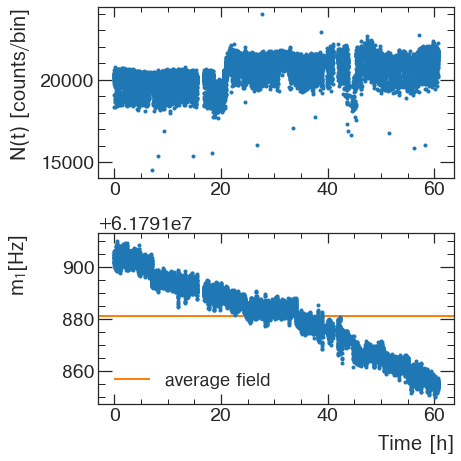

In [74]:
fig_name = 'fig_muon_avg_time'

x = (output_df['start_gps'] + output_df['end_gps']).values / 2
x = (x - x[0])/3600

y1 = output_df['ctags'].values
y2 = output_df['m1'].values + 61.74e6

mean_y2 = np.dot(y1,y2)/np.sum(y1)

fig7, axs7 = plt.subplots(2,1)

axs7[0].plot(x, y1, '.', markersize=6)
x1, x2 = axs7[0].get_xlim()
axs7[1].hlines(mean_y2, x1, x2, color='C1', label='average field')
axs7[1].plot(x, y2, '.', markersize=6)
axs7[1].set_xlim([x1,x2])
axs7[1].legend(loc='lower left')

axs7[0].set_ylabel('N(t) [counts/bin]', **ylabel_kwargs)
axs7[1].set_xlabel('Time [h]', **xlabel_kwargs)
axs7[1].set_ylabel(r'm$_1$[Hz]', **ylabel_kwargs)

fig7.align_ylabels()
fig7.set_size_inches(fig_width,1*fig_width)
fig7.tight_layout()

fig7.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs7, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

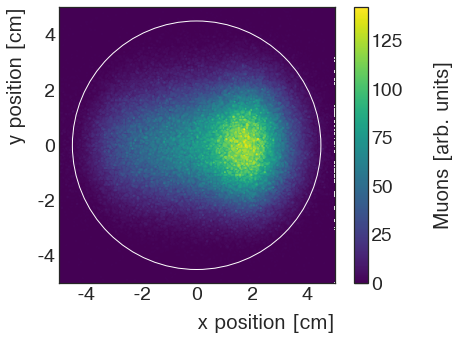

In [76]:
## fig:sample_muon_distribution

fig_name = 'fig_sample_muon_dist'

beam_filename = 'BeamSpot_'+str(beam_files[0][0])+'_'+str(beam_files[0][1])+'.root'

_beam, beam_x, beam_y = gm2.trfp.conv.loadBeamNew(beam_filename)
beam_x = beam_x/10
beam_y = beam_y/10
_beam = np.transpose(_beam)

X, Y = np.meshgrid(beam_x, beam_y)

fig8, axs8 = plt.subplots(1)

map8 = axs8.contourf(X, Y, _beam, levels=500, cmap='viridis')
axs8.set_aspect('equal')

axs8.add_artist(plt.Circle((0, 0), 4.5, fill=False))

axs8.set_xlim(-5,5)
axs8.set_ylim(-5,5)
axs8.set_xticks([-4, -2, 0, 2, 4])
axs8.set_yticks([-4, -2, 0, 2, 4])
axs8.set_xlabel('x position [cm]', **xlabel_kwargs)
axs8.set_ylabel('y position [cm]', **ylabel_kwargs)

cbar8 = fig8.colorbar(map8, shrink=1, ticks=[0, 25, 50, 75, 100, 125])
cbar8.set_label('Muons [arb. units]')

fig8.set_size_inches(fig_width, .75*fig_width)
fig8.tight_layout()

fig8.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs8, open('figures/run_1/'+fig_name+'.pickle', 'wb'))


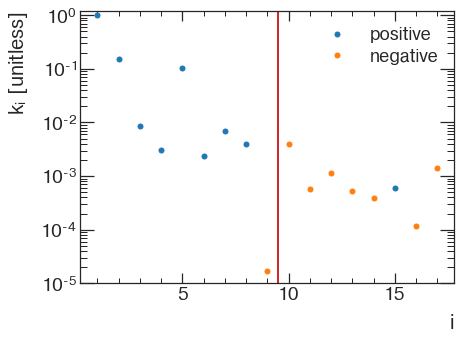

In [89]:
## fig:k_i_plot

fig_name = 'fig_k_i_plot'

def parameterize_beam(beam, beam_x, beam_y):
    x, y = np.meshgrid(beam_x, beam_y)

    dx = np.mean(np.diff(beam_x))
    dy = np.mean(np.diff(beam_y))
    
    _MULTIPOLE_ORDER = [0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 7, 7, 8, 10, 12]
    _MULTIPOLE_SKEW = [0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]

    order = _MULTIPOLE_ORDER
    skew = _MULTIPOLE_SKEW
    multipole = trfp.matrices.__multipole

    n = len(order)
    k = np.zeros(n)

    for i in range(n):
        f = multipole(order[i], skew[i], 1, x, y)
        k[i] = np.sum(f*beam*dx*dy)/np.sum(beam*dx*dy)
    return k

beam_avg = np.zeros([200,200])

for ii in range(len(beam_files)):
    
    beam_filename = 'BeamSpot_'+str(beam_files[ii][0])+'_'+str(beam_files[ii][1])+'.root'

    _beam, beam_x, beam_y = gm2.trfp.conv.loadBeamNew(beam_filename)
    beam_x = beam_x/10
    beam_y = beam_y/10
    _beam = np.transpose(_beam)
    beam_avg += _beam
    
k_avg = parameterize_beam(beam_avg, beam_x, beam_y)
# k_avg = k_avg[:9]

fig9, axs9 = plt.subplots(1)

axs9.semilogy(np.arange(1, k_avg.size+1), k_avg, '.', ms=10, label='positive')
axs9.semilogy(np.arange(1, k_avg.size+1), -k_avg, '.', ms=10, label='negative')
axs9.vlines(9.5, 1e-5, 1.2, color='C3')
axs9.set_ylim(1e-5, 1.2)
axs9.legend(markerscale=1)

axs9.set_ylabel(r'k$_i$ [unitless]', **ylabel_kwargs)
axs9.set_xlabel('i', **xlabel_kwargs)

fig9.set_size_inches(fig_width, .75*fig_width)
fig9.tight_layout()

fig9.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs9, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
###########################
### Run 1 Final Results ###
###########################

data_file = '/data2/aetb/2020-09-30_hybrid_maps.h5'

weight = (trfp.STATION_BARCODE_EDGES[1:] - trfp.STATION_BARCODE_EDGES[:-1])
weight[2] = (weight[2] + 360)
weight = weight/360

In [ ]:
# ## Run 1A

# ## load vtm data frame, get x, y values
# run = '1a'
# key = 'run_1a1'
# vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
# x, ys = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
# x = x[:ys.shape[0]]


# ## get trolley run times
# interp_file = map_config.interp_file_dict[run]
# tr_times = []
# for subrun in ['fp_df_1']:
#     for interp_key in map_config.pair_dict[run][subrun]:
#         interp_df = pd.read_hdf(interp_file, key=interp_key)
#         tr_times = tr_times + [np.mean(interp_df.index.values)]
        
# tr_times = np.array(tr_times)

# x0 = np.min(tr_times)
# x_tr = (tr_times - x0)/3600
# x = (x - x0)/3600.

# ## draw figures
# fig_name = 'fig_results_run_'
# fig_name = fig_name + run

# fig10, axs10 = plt.subplots(3,1, sharex=True)

# axs10[0].plot(x, ys[:,0] + 61.74e6, '.', ms=2, color='C0')
# y_low = np.quantile(ys[:,0] + 61.74e6, 0.1)
# y_high = np.quantile(ys[:,0] + 61.74e6, 0.9)
# y_diff = y_high - y_low
# axs10[0].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[0].get_ylim()
# axs10[0].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[0].set_ylabel('dipole [Hz]', **ylabel_kwargs)
# axs10[0].set_title('Run ' + run)

# axs10[1].plot(x, ys[:,1], '.', ms=2, color='C1')
# y_low = np.quantile(ys[:,1], 0.1)
# y_high = np.quantile(ys[:,1], 0.9)
# y_diff = y_high - y_low
# axs10[1].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[1].get_ylim()
# axs10[1].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[1].set_ylabel('nq [Hz]', **ylabel_kwargs)

# axs10[2].plot(x, ys[:,4], '.', ms=2, color='C2')
# y_low = np.quantile(ys[:,4], 0.1)
# y_high = np.quantile(ys[:,4], 0.9)
# y_diff = y_high - y_low
# axs10[2].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[2].get_ylim()
# axs10[2].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[2].set_ylabel('ns [Hz]', **ylabel_kwargs)
# axs10[2].set_xlabel('time [h]', **xlabel_kwargs)

# fig10.align_ylabels()
# fig10.set_size_inches(2*fig_width, 1*fig_width)
# fig10.tight_layout()

# fig10.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs10, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## Run 1B

# ## load vtm data frame, get x, y values
# run = '1b'
# key = 'run_1b1'
# vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
# x, ys = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
# x = x[:ys.shape[0]]

# key = 'run_1b2'
# vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
# x_, ys_ = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
# x = np.append(x, x_)
# ys = np.append(ys, ys_, axis=0)
# x = x[:ys.shape[0]]

# ## get trolley run times
# interp_file = map_config.interp_file_dict[run]
# tr_times = []
# for subrun in ['fp_df_1', 'fp_df_2']:
#     for interp_key in map_config.pair_dict[run][subrun]:
#         interp_df = pd.read_hdf(interp_file, key=interp_key)
#         tr_times = tr_times + [np.mean(interp_df.index.values)]
        
# tr_times = np.array(tr_times)

# x0 = np.min(tr_times)
# x_tr = (tr_times - x0)/3600
# x = (x - x0)/3600.
# x = x[:ys.shape[0]]

# ## draw figures
# fig_name = 'fig_results_run_'
# fig_name = fig_name + run

# fig10, axs10 = plt.subplots(3,1, sharex=True)

# axs10[0].plot(x, ys[:,0] + 61.74e6, '.', ms=2, color='C0')
# y_low = np.quantile(ys[:,0] + 61.74e6, 0.1)
# y_high = np.quantile(ys[:,0] + 61.74e6, 0.9)
# y_diff = y_high - y_low
# axs10[0].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[0].get_ylim()
# axs10[0].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[0].set_ylabel('dipole [Hz]', **ylabel_kwargs)
# axs10[0].set_title('Run ' + run)

# axs10[1].plot(x, ys[:,1], '.', ms=2, color='C1')
# y_low = np.quantile(ys[:,1], 0.1)
# y_high = np.quantile(ys[:,1], 0.9)
# y_diff = y_high - y_low
# axs10[1].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[1].get_ylim()
# axs10[1].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[1].set_ylabel('nq [Hz]', **ylabel_kwargs)

# axs10[2].plot(x, ys[:,4], '.', ms=2, color='C2')
# y_low = np.quantile(ys[:,4], 0.1)
# y_high = np.quantile(ys[:,4], 0.9)
# y_diff = y_high - y_low
# axs10[2].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[2].get_ylim()
# axs10[2].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[2].set_ylabel('ns [Hz]', **ylabel_kwargs)
# axs10[2].set_xlabel('time [h]', **xlabel_kwargs)

# fig10.align_ylabels()
# fig10.set_size_inches(2*fig_width, 1*fig_width)
# fig10.tight_layout()

# fig10.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs10, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## Run 1C

# ## load vtm data frame, get x, y values
# run = '1c'
# key = 'run_1c1'
# vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
# x, ys = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
# x = x[:ys.shape[0]]

# for key in ['run_1c2', 'run_1c3', 'run_1c4']:
#     vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
#     for m in range(9):
#         stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#         vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
#     x_, ys_ = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
#     x = np.append(x, x_)
#     ys = np.append(ys, ys_, axis=0)
#     x = x[:ys.shape[0]]

# ## get trolley run times
# interp_file = map_config.interp_file_dict[run]
# tr_times = []
# for subrun in ['fp_df_1', 'fp_df_2', 'fp_df_3', 'fp_df_4']:
#     for interp_key in map_config.pair_dict[run][subrun]:
#         interp_df = pd.read_hdf(interp_file, key=interp_key)
#         tr_times = tr_times + [np.mean(interp_df.index.values)]
        
# tr_times = np.array(tr_times)

# x0 = np.min(tr_times)
# x_tr = (tr_times - x0)/3600
# x = (x - x0)/3600.
# x = x[:ys.shape[0]]

# ## draw figures
# fig_name = 'fig_results_run_'
# fig_name = fig_name + run

# fig10, axs10 = plt.subplots(3,1, sharex=True)

# axs10[0].plot(x, ys[:,0] + 61.74e6, '.', ms=2, color='C0')
# y_low = np.quantile(ys[:,0] + 61.74e6, 0.1)
# y_high = np.quantile(ys[:,0] + 61.74e6, 0.9)
# y_diff = y_high - y_low
# axs10[0].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[0].get_ylim()
# axs10[0].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[0].set_ylabel('dipole [Hz]', **ylabel_kwargs)
# axs10[0].set_title('Run ' + run)

# axs10[1].plot(x, ys[:,1], '.', ms=2, color='C1')
# y_low = np.quantile(ys[:,1], 0.1)
# y_high = np.quantile(ys[:,1], 0.9)
# y_diff = y_high - y_low
# axs10[1].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[1].get_ylim()
# axs10[1].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[1].set_ylabel('nq [Hz]', **ylabel_kwargs)

# axs10[2].plot(x, ys[:,4], '.', ms=2, color='C2')
# y_low = np.quantile(ys[:,4], 0.1)
# y_high = np.quantile(ys[:,4], 0.9)
# y_diff = y_high - y_low
# axs10[2].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[2].get_ylim()
# axs10[2].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[2].set_ylabel('ns [Hz]', **ylabel_kwargs)
# axs10[2].set_xlabel('time [h]', **xlabel_kwargs)

# fig10.align_ylabels()
# fig10.set_size_inches(2*fig_width, 1*fig_width)
# fig10.tight_layout()

# fig10.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs10, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

In [ ]:
# ## Run 1D

# ## load vtm data frame, get x, y values
# run = '1d'
# key = 'run_1d2'
# vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
# for m in range(9):
#     stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#     vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
# x, ys = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
# x = x[:ys.shape[0]]

# for key in ['run_1d3', 'run_1d4', 'run_1d5', 'run_1d6']:
#     vtm_df = pd.read_hdf(data_file, key=key)[['st'+str(st)+',m'+str(m) for st in range(72) for m in range(1,10)]]
#     for m in range(9):
#         stm = ['st'+str(st)+',m'+str(m+1) for st in range(72)]
#         vtm_df['m'+str(m+1)] = vtm_df[stm].multiply(weight).sum(axis=1)
#     x_, ys_ = bins(vtm_df[['m'+str(m+1) for m in range(9)]], 1000)
#     x = np.append(x, x_)
#     ys = np.append(ys, ys_, axis=0)
#     x = x[:ys.shape[0]]

# ## get trolley run times
# interp_file = map_config.interp_file_dict[run]
# tr_times = []
# for subrun in ['fp_df_2', 'fp_df_3', 'fp_df_4', 'fp_df_5']:
#     for interp_key in map_config.pair_dict[run][subrun]:
#         interp_df = pd.read_hdf(interp_file, key=interp_key)
#         tr_times = tr_times + [np.mean(interp_df.index.values)]
        
# tr_times = np.array(tr_times)

# x0 = np.min(tr_times)
# x_tr = (tr_times - x0)/3600
# x = (x - x0)/3600.
# x = x[:ys.shape[0]]

# ## draw figures
# fig_name = 'fig_results_run_'
# fig_name = fig_name + run

# fig10, axs10 = plt.subplots(3,1, sharex=True)

# axs10[0].plot(x, ys[:,0] + 61.74e6, '.', ms=2, color='C0')
# y_low = np.quantile(ys[:,0] + 61.74e6, 0.1)
# y_high = np.quantile(ys[:,0] + 61.74e6, 0.9)
# y_diff = y_high - y_low
# axs10[0].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[0].get_ylim()
# axs10[0].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[0].set_ylabel('dipole [Hz]', **ylabel_kwargs)
# axs10[0].set_title('Run ' + run)

# axs10[1].plot(x, ys[:,1], '.', ms=2, color='C1')
# y_low = np.quantile(ys[:,1], 0.1)
# y_high = np.quantile(ys[:,1], 0.9)
# y_diff = y_high - y_low
# axs10[1].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[1].get_ylim()
# axs10[1].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[1].set_ylabel('nq [Hz]', **ylabel_kwargs)

# axs10[2].plot(x, ys[:,4], '.', ms=2, color='C2')
# y_low = np.quantile(ys[:,4], 0.1)
# y_high = np.quantile(ys[:,4], 0.9)
# y_diff = y_high - y_low
# axs10[2].set_ylim(y_low - 0.5*y_diff, y_high + 0.5*y_diff)
# ymin, ymax = axs10[2].get_ylim()
# axs10[2].vlines(x_tr, ymin, ymax, color='C3', linestyle='dashed')
# axs10[2].set_ylabel('ns [Hz]', **ylabel_kwargs)
# axs10[2].set_xlabel('time [h]', **xlabel_kwargs)

# fig10.align_ylabels()
# fig10.set_size_inches(2*fig_width, 1*fig_width)
# fig10.tight_layout()

# fig10.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
# pickle.dump(axs10, open('figures/run_1/'+fig_name+'.pickle', 'wb'))

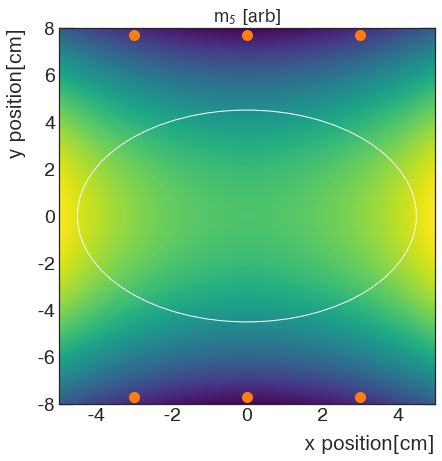

In [90]:
## sextupole aliasing figure

fig_name = 'fig_sext_alias'

multipole = trfp.matrices.__multipole

X, Y = np.meshgrid(np.linspace(-5,5,1001), np.linspace(-8,8,1001))

B = trfp.matrices.__multipole(2, 0, 1, X, Y)

fig11, axs11 = plt.subplots(1)

map11 = axs11.contourf(X, Y, B, levels=500, cmap='viridis')
axs11.set_aspect(5./8.)

axs11.plot(trfp.geometry.FP6_X, trfp.geometry.FP6_Y, '.', ms=20, color='C1')

axs11.add_artist(plt.Circle((0, 0), 4.5, fill=False))

axs11.set_xlim(-5,5)
axs11.set_ylim(-8,8)
axs11.set_xticks([-4, -2, 0, 2, 4])
axs11.set_yticks([-8, -6, -4, -2, 0, 2, 4, 6, 8])
axs11.set_xlabel('x position[cm]', **xlabel_kwargs)
axs11.set_ylabel('y position[cm]', **ylabel_kwargs)

axs11.set_title(r'm$_5$ [arb]')

fig11.set_size_inches(fig_width, fig_width)
fig11.tight_layout()

fig11.savefig('figures/run_1/'+fig_name+'.png', dpi=300)
pickle.dump(axs11, open('figures/run_1/'+fig_name+'.pickle', 'wb'))


In [ ]:
## trolley footprint figure

fig_name = 'fig_trolley_footprint'

fig12, axs12 = plt.subplots(1,1)

data = np.genfromtxt('trolletMagneticFootprint9cm.dat')

axs12.plot(data[0,:]/10., data[1,:], '.', ms=4)

axs12.set_xlim((-10,45))
axs12.set_ylim((0,250))

axs12.axvspan(-0.5,0.5, 0, 250, ls='dashed', color='C1', alpha=0.5, label='active volume')
axs12.legend(loc='lower right')

axs12.set_xlabel('Position [cm]', **xlabel_kwargs)
axs12.set_ylabel('Perturbation [Hz]', **ylabel_kwargs)

fig12.set_size_inches(fig_width, fig_width/1.618)
fig12.tight_layout()

# fig13, axs13 = plt.subplots(1,1)

# axs13.plot(data[0,:]/10., data[1,:], '.', ms=4)

# axs13.set_xlim((-10,45))
# axs13.set_ylim((0,250))

# axs13.axvspan(-0.5,0.5, 0, 250, ls='dashed', color='C1', alpha=0.5, label='active volume')
# axs13.legend(loc='lower right')

# axs13.set_xlabel('Position [cm]', fontsize=10, labelpad=15, **xlabel_kwargs)
# axs13.set_ylabel('Perturbation [Hz]', **ylabel_kwargs)

# fig13.set_size_inches(fig_width, fig_width/1.618)
# fig13.tight_layout()

# fig12.savefig('figures/run_1/'+fig_name+'.png')
# pickle.dump(axs12, open('figures/run_1/'+fig_name+'.pickle', 'wb'))